In [1]:
!pip install tabulate

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import gc

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8')

from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/SU Works/CPSC_5305_Intro_to_DS/Rizvans Works/Saved Data/cleaned_data.parquet"

Mounted at /content/drive


In [3]:
cleaned_df = pd.read_parquet(DATA_PATH)

In [4]:
print(cleaned_df.head().to_markdown())

|    | date                |   wm_yr_wk | weekday   |   wday |   month |   year | d   | event_name_1   | event_type_1   | event_name_2   | event_type_2   |   snap_CA |   snap_TX |   snap_WI | id                            | item_id       | dept_id   | cat_id   | store_id   | state_id   |   sales_count |   sell_price |
|---:|:--------------------|-----------:|:----------|-------:|--------:|-------:|:----|:---------------|:---------------|:---------------|:---------------|----------:|----------:|----------:|:------------------------------|:--------------|:----------|:---------|:-----------|:-----------|--------------:|-------------:|
|  0 | 2011-01-29 00:00:00 |      11101 | Saturday  |      1 |       1 |   2011 | d_1 | No Event       | No Event       | No Event       | No Event       |         0 |         0 |         0 | HOBBIES_1_001_CA_1_evaluation | HOBBIES_1_001 | HOBBIES_1 | HOBBIES  | CA_1       | CA         |             0 |         9.58 |
|  1 | 2011-01-29 00:00:00 |      11101 

### Combined SNAP

The snap day information is spread across three columns when it could be in one. For any given row (which corresponds to a specific store), only one of those columns is relevant.

In [5]:
cleaned_df['snap'] = 0

In [6]:
# Set 'snap' to 1 where the state is CA and snap_CA is 1
cleaned_df.loc[(cleaned_df['state_id'] == 'CA') & (cleaned_df['snap_CA'] == 1), 'snap'] = 1

# Set 'snap' to 1 where the state is TX and snap_TX is 1
cleaned_df.loc[(cleaned_df['state_id'] == 'TX') & (cleaned_df['snap_TX'] == 1), 'snap'] = 1

# Set 'snap' to 1 where the state is WI and snap_WI is 1
cleaned_df.loc[(cleaned_df['state_id'] == 'WI') & (cleaned_df['snap_WI'] == 1), 'snap'] = 1

In [7]:
cleaned_df.drop(['snap_CA', 'snap_TX', 'snap_WI'], axis=1, inplace=True)

In [8]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 20 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   wm_yr_wk      int16         
 2   weekday       object        
 3   wday          int8          
 4   month         int8          
 5   year          int16         
 6   d             object        
 7   event_name_1  category      
 8   event_type_1  category      
 9   event_name_2  category      
 10  event_type_2  category      
 11  id            object        
 12  item_id       category      
 13  dept_id       category      
 14  cat_id        category      
 15  store_id      category      
 16  state_id      category      
 17  sales_count   float32       
 18  sell_price    float32       
 19  snap          int64         
dtypes: category(9), datetime64[ns](1), float32(2), int16(2), int64(1), int8(2), object(3)
memory usage: 3.5+ GB


 weekday is the name of the day (e.g., "Saturday") and wday is its numerical ID (e.g., 1 for Saturday). These two columns contain the exact same information, just in different formats. Keeping both is redundant.
 We will only keep the wday column. The mapping is as below:  
 | wday | Day of the Week |
|-------------|-----------------|
| 1           | Saturday        |
| 2           | Sunday          |
| 3           | Monday          |
| 4           | Tuesday         |
| 5           | Wednesday       |
| 6           | Thursday        |
| 7           | Friday          |

we can also also add a column that indicates if it was a weekend or not (as sales usually goes up during the weekend)

In [9]:
cleaned_df.drop('weekday', axis=1, inplace=True)
cleaned_df['wday'] = cleaned_df['wday'].astype('category')
cleaned_df['weekend'] = cleaned_df['wday'].apply(lambda x: 1 if x in [1, 2] else 0)

The `id` column is just a concatenation of `item_id`, `store_id`, and the word "evaluation" (e.g., `HOBBIES_1_156_CA_2_evaluation`). This creates a unique string for every single time series. A machine learning model can't learn anything useful from this single, combined ID. It learns much more from the individual components:
It can learn the general sales pattern for all `HOBBIES_1` items.
It can learn the behavior of all items sold in the `CA_2` store.
The combined `id` just acts as a unique identifier and adds noise. It is better if we drop it

the `d` column represents the day number in the format `d_1`, `d_2`, etc. Like `wm_yr_wk`, it's a time index, but at the daily level. However, unlike wm_yr_wk, it's a string and has very high cardinality (1,941 unique values). The `date` column and the time-based features we will create from it (like day_of_year) are much more powerful for a model.

In [10]:
cleaned_df.drop(['id', 'd'], axis=1, inplace=True)

In [11]:
print(cleaned_df.head().to_markdown())

|    | date                |   wm_yr_wk |   wday |   month |   year | event_name_1   | event_type_1   | event_name_2   | event_type_2   | item_id       | dept_id   | cat_id   | store_id   | state_id   |   sales_count |   sell_price |   snap |   weekend |
|---:|:--------------------|-----------:|-------:|--------:|-------:|:---------------|:---------------|:---------------|:---------------|:--------------|:----------|:---------|:-----------|:-----------|--------------:|-------------:|-------:|----------:|
|  0 | 2011-01-29 00:00:00 |      11101 |      1 |       1 |   2011 | No Event       | No Event       | No Event       | No Event       | HOBBIES_1_001 | HOBBIES_1 | HOBBIES  | CA_1       | CA         |             0 |         9.58 |      0 |         1 |
|  1 | 2011-01-29 00:00:00 |      11101 |      1 |       1 |   2011 | No Event       | No Event       | No Event       | No Event       | HOBBIES_1_002 | HOBBIES_1 | HOBBIES  | CA_1       | CA         |             0 |         3.97 |  

# Calendar Features

In [12]:
cleaned_df['quarter'] = cleaned_df['date'].dt.quarter
cleaned_df['week_of_year'] = cleaned_df['date'].dt.isocalendar().week.astype(int)
cleaned_df['day_of_year'] = cleaned_df['date'].dt.dayofyear
cleaned_df['day_of_month'] = cleaned_df['date'].dt.day

For a month-based feature, let's first investigate how average sales impact each day of the month.

In [13]:
print(f"Earliest date: {cleaned_df['date'].min()}")
print(f"Latest date: {cleaned_df['date'].max()}")

Earliest date: 2011-01-29 00:00:00
Latest date: 2016-05-22 00:00:00


In [14]:
filtered_df = cleaned_df[(cleaned_df['year'] >= 2012) & (cleaned_df['year'] <= 2015)].copy()

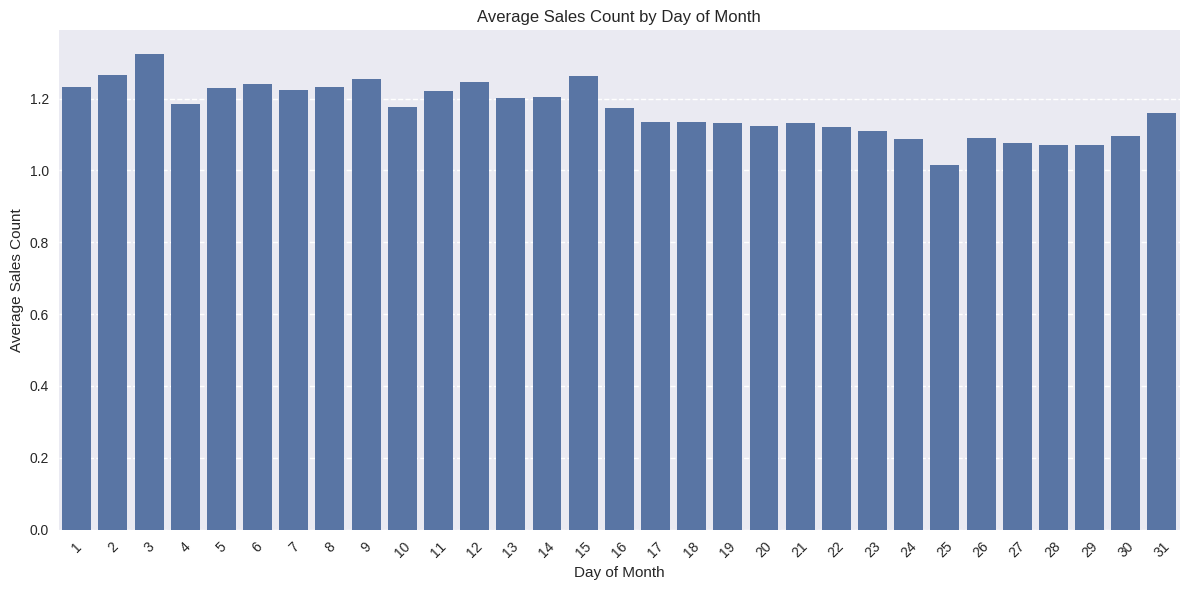

181

In [15]:
sales_by_day_of_month = filtered_df.groupby('day_of_month')['sales_count'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_month', y='sales_count', data=sales_by_day_of_month)
plt.title('Average Sales Count by Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Average Sales Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

del sales_by_day_of_month
gc.collect()

Looks like generally, the sales amount tends to be higher at the starting half of the month. Maybe because people usually gets paid at the start or middle of the month and buy more items? We can add a feature called `payday` that reflects this.

In [16]:
cleaned_df['payday'] = cleaned_df['day_of_month'].apply(lambda x: 1 if (x < 4) or (14 <= x <= 16) else 0)

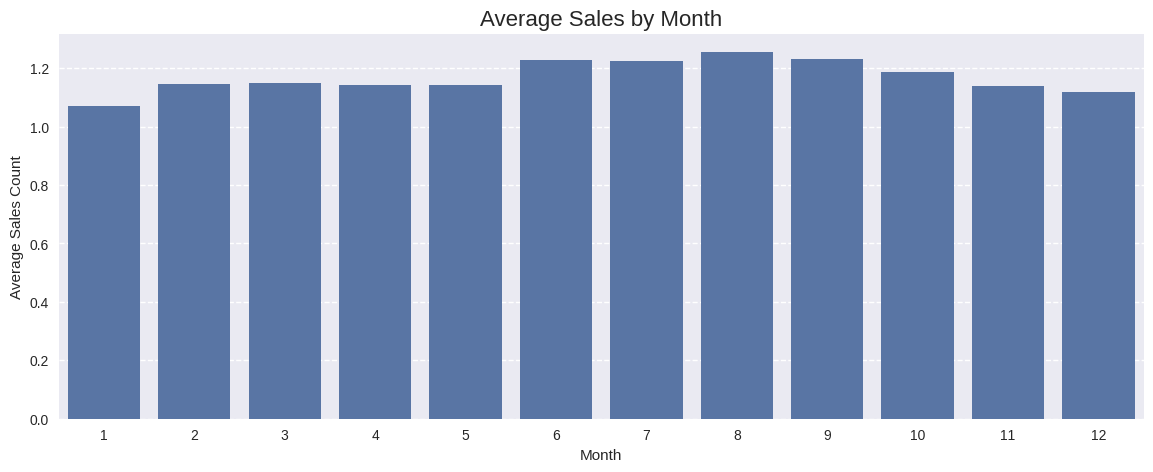

8872

In [17]:
sales_by_day_of_year = filtered_df.groupby('month')['sales_count'].mean().reset_index()

# Create the plot
plt.figure(figsize=(14, 5))
sns.barplot(x='month', y='sales_count', data=sales_by_day_of_year)
plt.title('Average Sales by Month', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Average Sales Count')
plt.grid(axis='y', linestyle='--')
plt.show()

del sales_by_day_of_year, filtered_df
gc.collect()

Seems like sales usually go up during the summer months, so we can add this seasonality as well.

In [18]:
cleaned_df['summer'] = cleaned_df['month'].isin([6, 7, 8, 9]).astype(int)

In [19]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 24 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   wm_yr_wk      int16         
 2   wday          category      
 3   month         int8          
 4   year          int16         
 5   event_name_1  category      
 6   event_type_1  category      
 7   event_name_2  category      
 8   event_type_2  category      
 9   item_id       category      
 10  dept_id       category      
 11  cat_id        category      
 12  store_id      category      
 13  state_id      category      
 14  sales_count   float32       
 15  sell_price    float32       
 16  snap          int64         
 17  weekend       int8          
 18  quarter       int32         
 19  week_of_year  int64         
 20  day_of_year   int32         
 21  day_of_month  int32         
 22  payday        int64         
 23  summer        int64         
d

# Cyclical Features
https://towardsdatascience.com/cyclical-encoding-an-alternative-to-one-hot-encoding-for-time-series-features-4db46248ebba/

In [20]:
# Downcast integer columns to the smallest possible type
for col in ['snap', 'quarter', 'week_of_year', 'day_of_month', 'payday', 'summer']:
    cleaned_df[col] = pd.to_numeric(cleaned_df[col], downcast='integer')

cleaned_df['day_of_year'] = pd.to_numeric(cleaned_df['day_of_year'], downcast='unsigned') # Use unsigned for positive-only numbers

print("--- Dtypes after optimization ---")
print(cleaned_df.info())

--- Dtypes after optimization ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 24 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   wm_yr_wk      int16         
 2   wday          category      
 3   month         int8          
 4   year          int16         
 5   event_name_1  category      
 6   event_type_1  category      
 7   event_name_2  category      
 8   event_type_2  category      
 9   item_id       category      
 10  dept_id       category      
 11  cat_id        category      
 12  store_id      category      
 13  state_id      category      
 14  sales_count   float32       
 15  sell_price    float32       
 16  snap          int8          
 17  weekend       int8          
 18  quarter       int8          
 19  week_of_year  int8          
 20  day_of_year   uint16        
 21  day_of_month  int8          
 22  payday        int8          
 

In [21]:
# Month
cleaned_df['month_sin'] = np.sin(2 * np.pi * cleaned_df['month']/12)
cleaned_df['month_cos'] = np.cos(2 * np.pi * cleaned_df['month']/12)

# Day of month
cleaned_df['day_of_month_sin'] = np.sin(2 * np.pi * cleaned_df['day_of_month']/31)
cleaned_df['day_of_month_cos'] = np.cos(2 * np.pi * cleaned_df['day_of_month']/31)

# Day of week
cleaned_df['wday_numeric'] = cleaned_df['wday'].astype(int)
cleaned_df['day_of_week_sin'] = np.sin(2 * np.pi * cleaned_df['wday_numeric']/7)
cleaned_df['day_of_week_cos'] = np.cos(2 * np.pi * cleaned_df['wday_numeric']/7)

print("\nCyclical features added.")


Cyclical features added.


In [22]:
cleaned_df.drop(columns=['month', 'day_of_month', 'wday', 'wday_numeric'], inplace=True)
print(cleaned_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 27 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   wm_yr_wk          int16         
 2   year              int16         
 3   event_name_1      category      
 4   event_type_1      category      
 5   event_name_2      category      
 6   event_type_2      category      
 7   item_id           category      
 8   dept_id           category      
 9   cat_id            category      
 10  store_id          category      
 11  state_id          category      
 12  sales_count       float32       
 13  sell_price        float32       
 14  snap              int8          
 15  weekend           int8          
 16  quarter           int8          
 17  week_of_year      int8          
 18  day_of_year       uint16        
 19  payday            int8          
 20  summer            int8          
 21  month_

In [23]:
for col in ['month_sin', 'month_cos', 'day_of_month_sin', 'day_of_month_cos', 'day_of_week_sin', 'day_of_week_cos']:
    cleaned_df[col] = cleaned_df[col].astype('float32')

In [24]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 27 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   wm_yr_wk          int16         
 2   year              int16         
 3   event_name_1      category      
 4   event_type_1      category      
 5   event_name_2      category      
 6   event_type_2      category      
 7   item_id           category      
 8   dept_id           category      
 9   cat_id            category      
 10  store_id          category      
 11  state_id          category      
 12  sales_count       float32       
 13  sell_price        float32       
 14  snap              int8          
 15  weekend           int8          
 16  quarter           int8          
 17  week_of_year      int8          
 18  day_of_year       uint16        
 19  payday            int8          
 20  summer            int8          
 21  month_

In [25]:
numerical_df = cleaned_df.select_dtypes(include=np.number)
corr_matrix = numerical_df.corr()

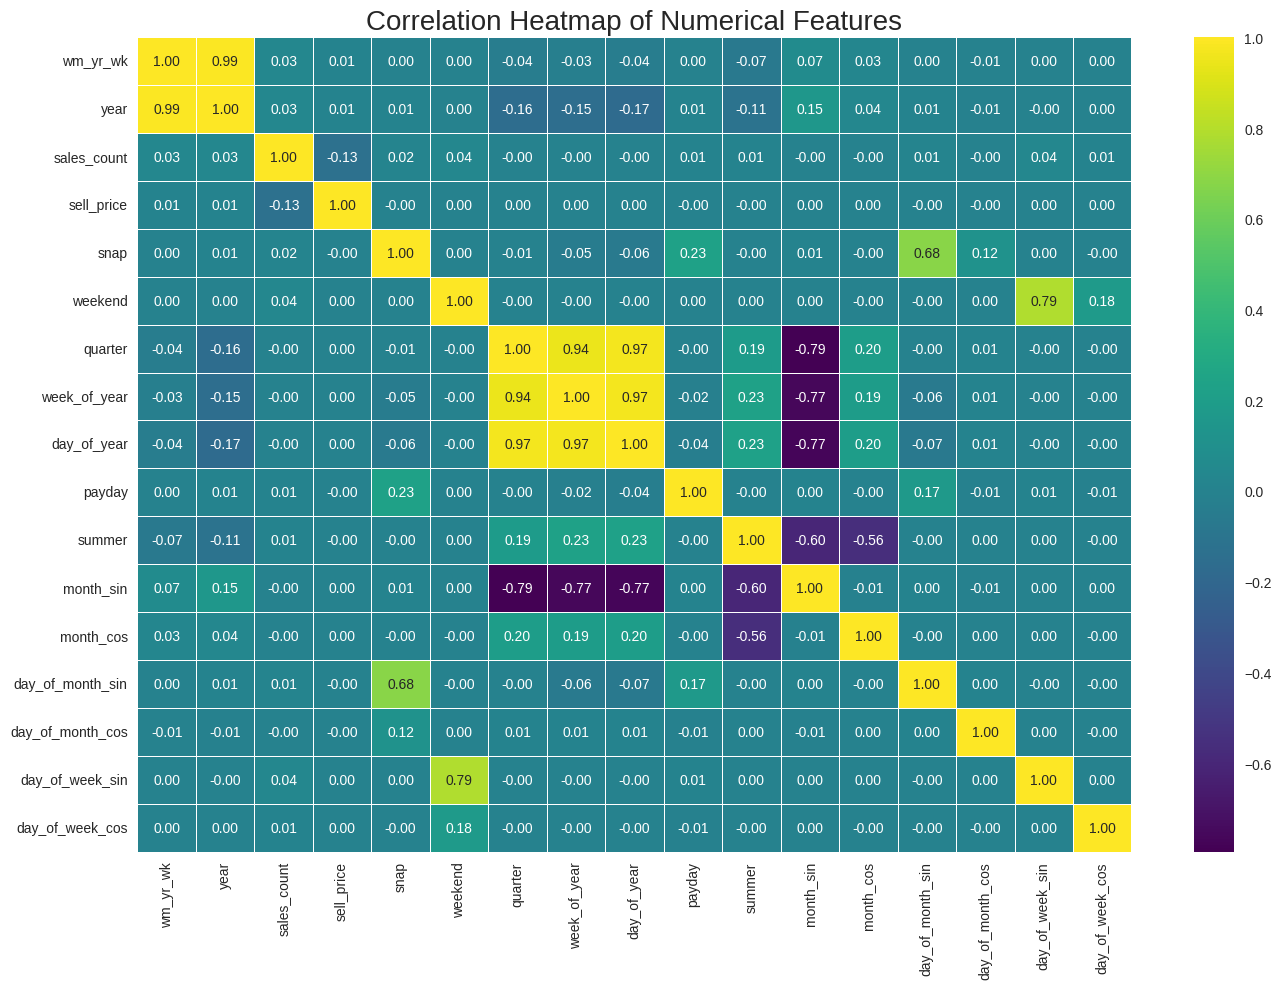

In [26]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='viridis',
    fmt='.2f',
    linewidths=.5
)

plt.title('Correlation Heatmap of Numerical Features', fontsize=20)
plt.tight_layout()
plt.show()

# Price-based features

In [27]:
cleaned_df.sort_values(by=['item_id', 'store_id', 'date'], inplace=True)

In [28]:
df_features = cleaned_df # This makes df_features reference the same object as cleaned_df

# Define the lag and rolling periods you want to test
periods = [1, 7, 15, 28]
grouped = df_features.groupby(['item_id', 'store_id'], observed=True)

print("Starting creation of extended lag and rolling features...")

for period in periods:
    # --- Lag Features ---
    # Price from 'period' days ago
    df_features[f'price_lag_{period}'] = grouped['sell_price'].shift(period)

    # Difference between current price and price from 'period' days ago
    df_features[f'price_diff_{period}'] = df_features['sell_price'] - df_features[f'price_lag_{period}']

    # --- Rolling Features ---
    # Rolling mean price over the last 'period' days
    df_features[f'price_rolling_mean_{period}'] = grouped['sell_price'].transform(
        lambda x: x.rolling(period).mean()
    )

    # Rolling standard deviation of price over the last 'period' days
    df_features[f'price_rolling_std_{period}'] = grouped['sell_price'].transform(
        lambda x: x.rolling(period).std()
    )

print("Extended features created.")

# --- Handle the new NaNs ---
# These new features will create many more NaNs (e.g., the first 364 days for the 365-day features)
# We will use the same logical imputation strategy

print("Imputing NaN values...")

for period in periods:
    # Fill differences with 0 (assuming no change)
    df_features[f'price_diff_{period}'] = df_features[f'price_diff_{period}'].fillna(0)

    # Fill rolling std with 0 (assuming no volatility)
    df_features[f'price_rolling_std_{period}'] = df_features[f'price_rolling_std_{period}'].fillna(0)

    # For lags and rolling means, you could fill with 0, but backfilling might be more logical
    # Here, we will backfill within each group to use the first available valid value
    df_features[f'price_lag_{period}'] = grouped[f'price_lag_{period}'].transform(lambda x: x.bfill().ffill())
    df_features[f'price_rolling_mean_{period}'] = grouped[f'price_rolling_mean_{period}'].transform(lambda x: x.bfill().ffill())


print("NaNs handled.")
gc.collect()

Starting creation of extended lag and rolling features...
Extended features created.
Imputing NaN values...
NaNs handled.


0

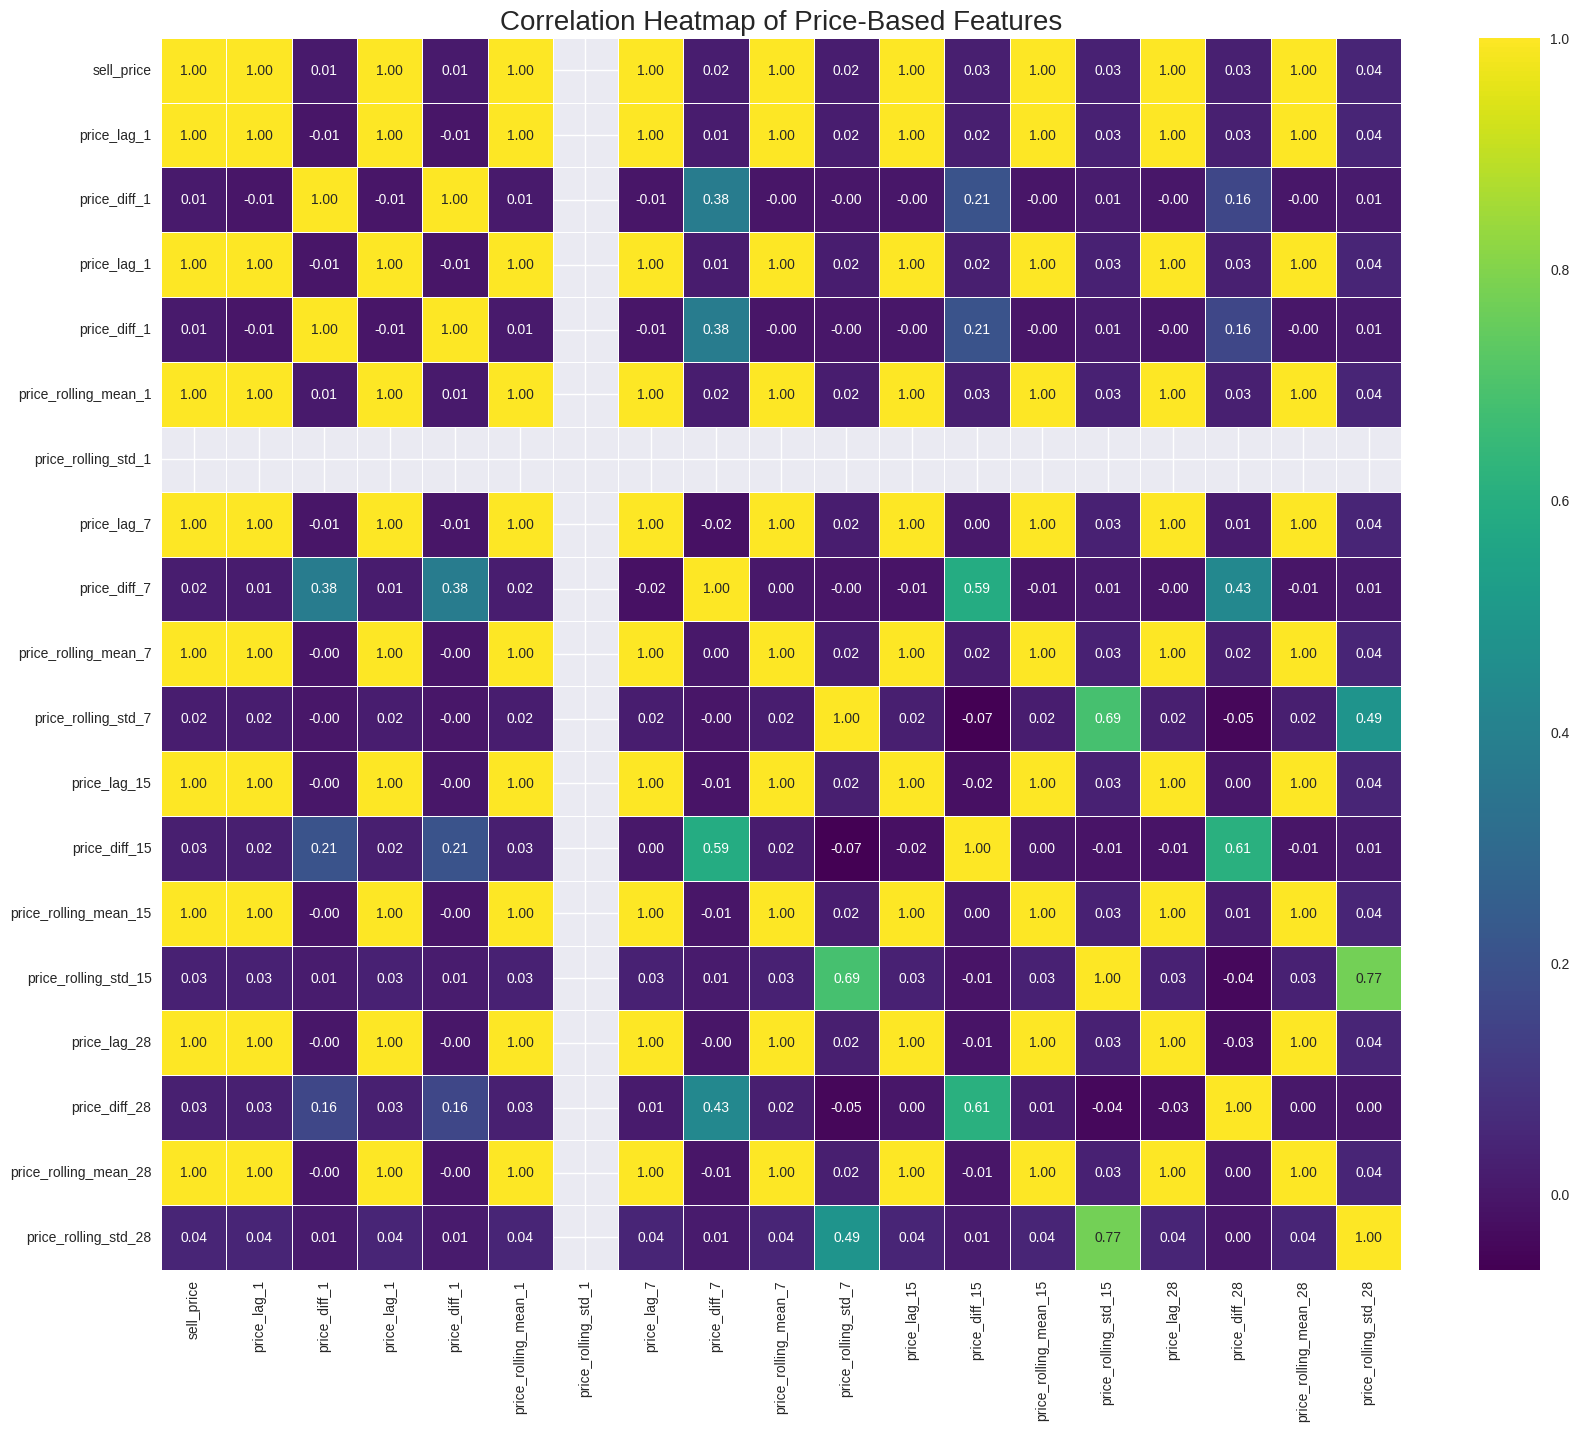

In [29]:
# Select only the price-based features for clarity
price_features = ['sell_price', 'price_lag_1', 'price_diff_1'] # Assuming you kept the originals
for period in periods:
    price_features.extend([
        f'price_lag_{period}',
        f'price_diff_{period}',
        f'price_rolling_mean_{period}',
        f'price_rolling_std_{period}'
    ])

# Calculate the correlation matrix
corr_matrix = df_features[price_features].corr()

# Plot the heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='viridis',
    fmt='.2f',
    linewidths=.5
)
plt.title('Correlation Heatmap of Price-Based Features', fontsize=20)
plt.show()

In [30]:
print(df_features.isna().sum())

date                     0
wm_yr_wk                 0
year                     0
event_name_1             0
event_type_1             0
event_name_2             0
event_type_2             0
item_id                  0
dept_id                  0
cat_id                   0
store_id                 0
state_id                 0
sales_count              0
sell_price               0
snap                     0
weekend                  0
quarter                  0
week_of_year             0
day_of_year              0
payday                   0
summer                   0
month_sin                0
month_cos                0
day_of_month_sin         0
day_of_month_cos         0
day_of_week_sin          0
day_of_week_cos          0
price_lag_1              0
price_diff_1             0
price_rolling_mean_1     0
price_rolling_std_1      0
price_lag_7              0
price_diff_7             0
price_rolling_mean_7     0
price_rolling_std_7      0
price_lag_15             0
price_diff_15            0
p

# Sales-based features

In [31]:
# First, sort the dataframe to ensure correct ordering for lag/rolling features
df_features = cleaned_df.copy() # Create a copy to work with
df_features.sort_values(by=['item_id', 'store_id', 'date'], inplace=True)

# Group by each individual time series
grouped = df_features.groupby(['item_id', 'store_id'], observed=True)

# Define the lag and rolling periods
periods = [1, 7, 15, 28]

print("Starting creation of extended sales lag and rolling features...")

for period in periods:
    # --- Lag Features ---
    # Sales count from 'period' days ago
    print(f"  Creating sales_lag_{period}...")
    df_features[f'sales_lag_{period}'] = grouped['sales_count'].shift(period)

    # --- Rolling Mean Features ---
    # Rolling mean of sales over the last 'period' days
    print(f"  Creating sales_rolling_mean_{period}...")
    df_features[f'sales_rolling_mean_{period}'] = grouped['sales_count'].shift(1).transform(
        lambda x: x.rolling(period, min_periods=1).mean()
    )

    # --- Rolling Standard Deviation Features ---
    # Rolling standard deviation of sales over the last 'period' days
    print(f"  Creating sales_rolling_std_{period}...")
    df_features[f'sales_rolling_std_{period}'] = grouped['sales_count'].shift(1).transform(
        lambda x: x.rolling(period, min_periods=1).std()
    )

print("Extended sales features created.")

# --- Handle NaN Values ---
print("Handling NaN values...")
for period in periods:
    df_features[f'sales_lag_{period}'].fillna(0, inplace=True)
    df_features[f'sales_rolling_mean_{period}'].fillna(0, inplace=True)
    df_features[f'sales_rolling_std_{period}'].fillna(0, inplace=True)

print("Sales-based features have been created and NaNs have been handled.")

# Display the new columns and their types
df_features.info()

Starting creation of extended sales lag and rolling features...
  Creating sales_lag_1...
  Creating sales_rolling_mean_1...
  Creating sales_rolling_std_1...
  Creating sales_lag_7...
  Creating sales_rolling_mean_7...
  Creating sales_rolling_std_7...
  Creating sales_lag_15...
  Creating sales_rolling_mean_15...
  Creating sales_rolling_std_15...
  Creating sales_lag_28...
  Creating sales_rolling_mean_28...
  Creating sales_rolling_std_28...
Extended sales features created.
Handling NaN values...


/tmp/ipython-input-2942554632.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_features[f'sales_lag_{period}'].fillna(0, inplace=True)
/tmp/ipython-input-2942554632.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

Sales-based features have been created and NaNs have been handled.
<class 'pandas.core.frame.DataFrame'>
Index: 59181090 entries, 1612 to 59179652
Data columns (total 55 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   date                   datetime64[ns]
 1   wm_yr_wk               int16         
 2   year                   int16         
 3   event_name_1           category      
 4   event_type_1           category      
 5   event_name_2           category      
 6   event_type_2           category      
 7   item_id                category      
 8   dept_id                category      
 9   cat_id                 category      
 10  store_id               category      
 11  state_id               category      
 12  sales_count            float32       
 13  sell_price             float32       
 14  snap                   int8          
 15  weekend                int8          
 16  quarter                int8          
 17

In [32]:
del cleaned_df, grouped
gc.collect()

25333

Calculation complete.


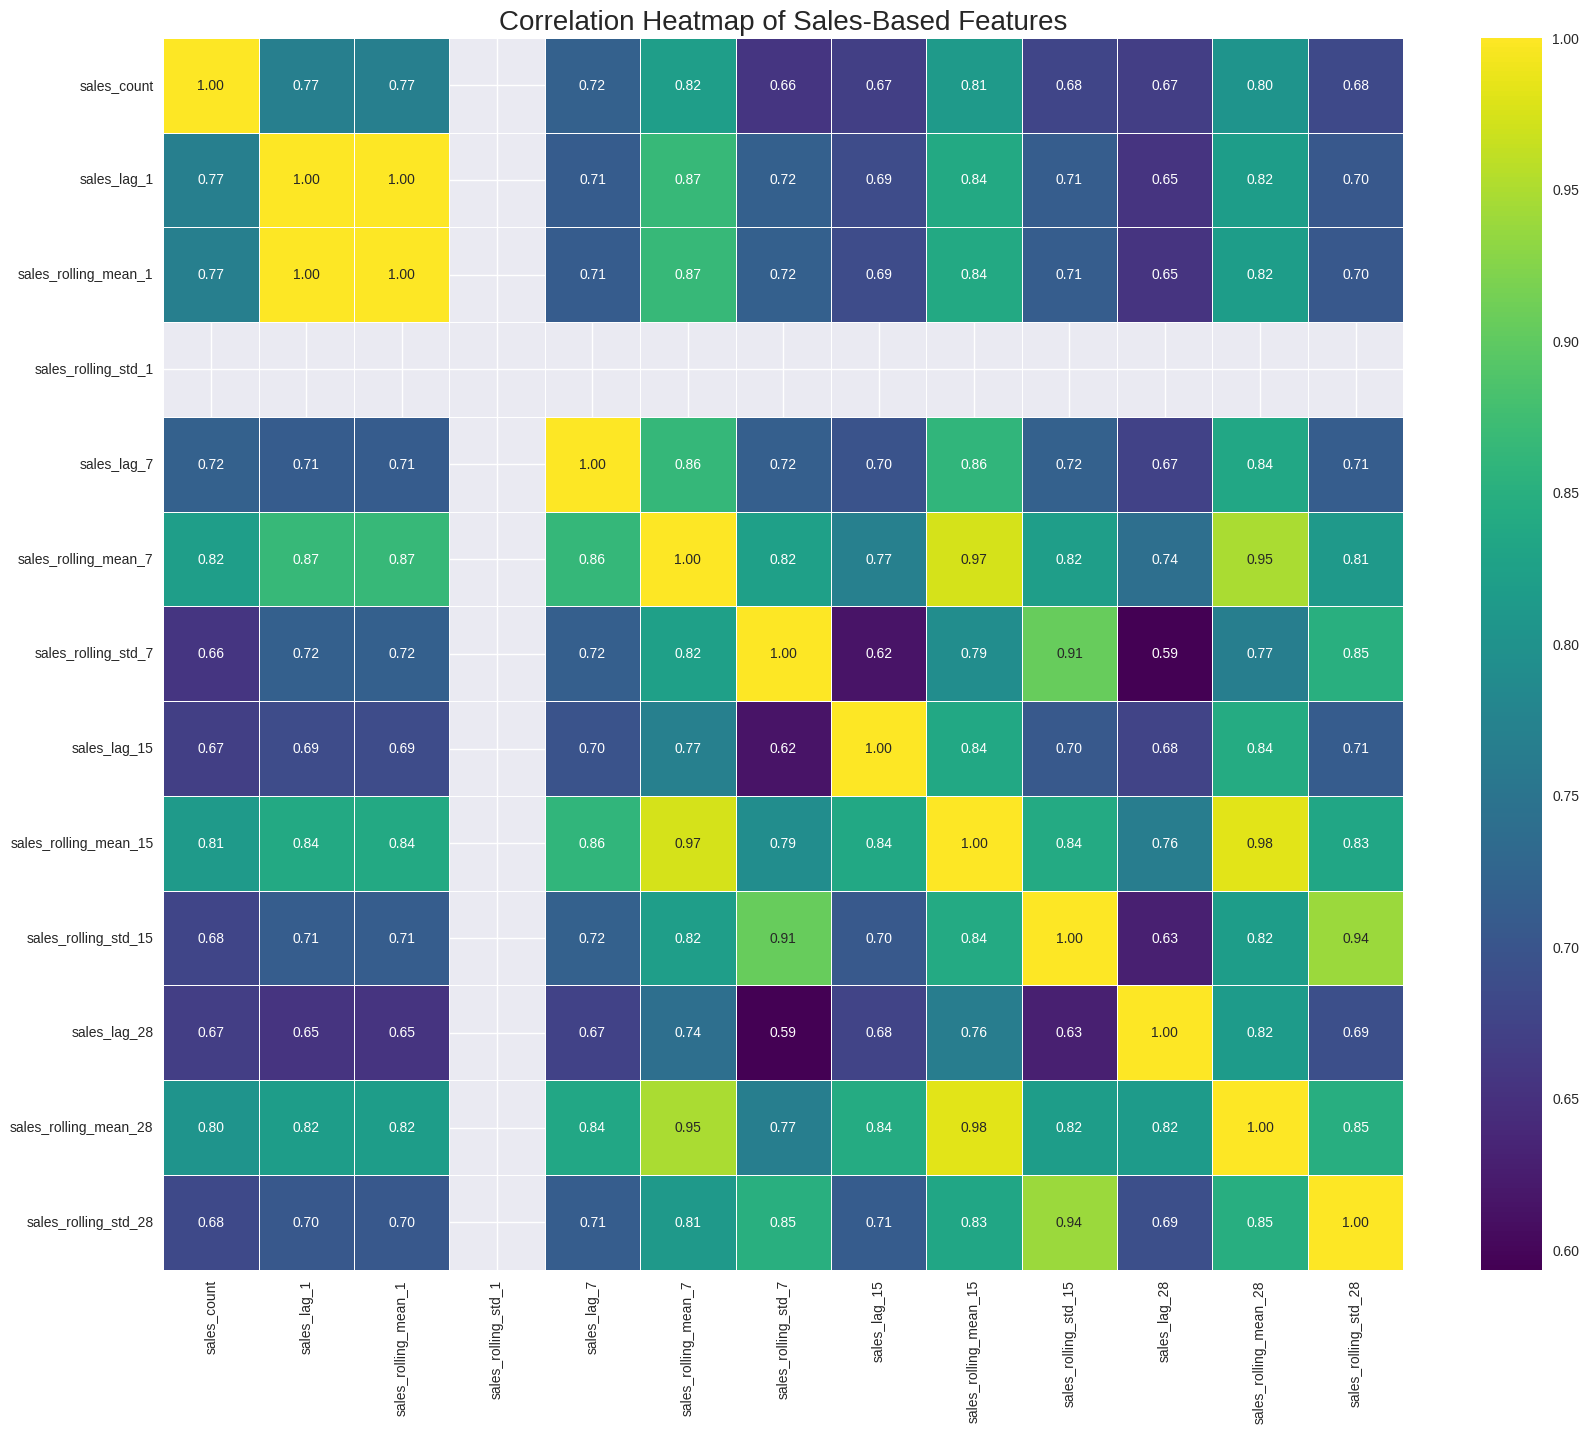

In [33]:
# Select only the sales-based features for clarity
sales_features = ['sales_count'] # Start with the target variable
periods = [1, 7, 15, 28]

for period in periods:
    sales_features.extend([
        f'sales_lag_{period}',
        f'sales_rolling_mean_{period}',
        f'sales_rolling_std_{period}'
    ])

# Calculate the correlation matrix on the sample
corr_matrix_sales = df_features[sales_features].corr()
print("Calculation complete.")

# Plot the heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(
    corr_matrix_sales,
    annot=True,
    cmap='viridis',
    fmt='.2f',
    linewidths=.5
)
plt.title('Correlation Heatmap of Sales-Based Features', fontsize=20)
plt.show()

In [34]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage decreased to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

In [35]:
final_df = reduce_mem_usage(df_features)
del df_features
gc.collect()

Memory usage decreased to 10272.08 Mb (26.0% reduction)


14485

In [36]:
print(final_df.isna().sum().to_markdown())

|                       |   0 |
|:----------------------|----:|
| date                  |   0 |
| wm_yr_wk              |   0 |
| year                  |   0 |
| event_name_1          |   0 |
| event_type_1          |   0 |
| event_name_2          |   0 |
| event_type_2          |   0 |
| item_id               |   0 |
| dept_id               |   0 |
| cat_id                |   0 |
| store_id              |   0 |
| state_id              |   0 |
| sales_count           |   0 |
| sell_price            |   0 |
| snap                  |   0 |
| weekend               |   0 |
| quarter               |   0 |
| week_of_year          |   0 |
| day_of_year           |   0 |
| payday                |   0 |
| summer                |   0 |
| month_sin             |   0 |
| month_cos             |   0 |
| day_of_month_sin      |   0 |
| day_of_month_cos      |   0 |
| day_of_week_sin       |   0 |
| day_of_week_cos       |   0 |
| price_lag_1           |   0 |
| price_diff_1          |   0 |
| price_

In [37]:
# Let's order the columns for a more intuitive and organized DataFrame structure

final_column_order = [
    # 1. Identifier Columns
    'item_id',
    'dept_id',
    'cat_id',
    'store_id',
    'state_id',

    # 2. Date & Time Index Columns
    'date',
    'wm_yr_wk',
    'year',

    # 3. Engineered Calendar Features
    'quarter',
    'week_of_year',
    'day_of_year',
    'weekend',
    'payday',
    'summer',
    'month_sin',
    'month_cos',
    'day_of_month_sin',
    'day_of_month_cos',
    'day_of_week_sin',
    'day_of_week_cos',

    # 4. Event & SNAP Features
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'snap',

    # 5. Raw Price & Sales Features
    'sell_price',
    'sales_count', # Temporarily here, will be moved to the end

    # 6. Engineered Price Features
    'price_lag_1', 'price_diff_1', 'price_rolling_mean_1', 'price_rolling_std_1',
    'price_lag_7', 'price_diff_7', 'price_rolling_mean_7', 'price_rolling_std_7',
    'price_lag_15', 'price_diff_15', 'price_rolling_mean_15', 'price_rolling_std_15',
    'price_lag_28', 'price_diff_28', 'price_rolling_mean_28', 'price_rolling_std_28',

    # 7. Engineered Sales Features
    'sales_lag_1', 'sales_rolling_mean_1', 'sales_rolling_std_1',
    'sales_lag_7', 'sales_rolling_mean_7', 'sales_rolling_std_7',
    'sales_lag_15', 'sales_rolling_mean_15', 'sales_rolling_std_15',
    'sales_lag_28', 'sales_rolling_mean_28', 'sales_rolling_std_28',
]

# Ensure sales_count is the last column
target_column = 'sales_count'
final_column_order.remove(target_column)
final_column_order.append(target_column)

# Reorder the DataFrame
final_df = final_df[final_column_order]

print("--- DataFrame has been successfully reordered! ---")

# Display the new structure to confirm
final_df.info()

--- DataFrame has been successfully reordered! ---
<class 'pandas.core.frame.DataFrame'>
Index: 59181090 entries, 1612 to 59179652
Data columns (total 55 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   item_id                category      
 1   dept_id                category      
 2   cat_id                 category      
 3   store_id               category      
 4   state_id               category      
 5   date                   datetime64[ns]
 6   wm_yr_wk               int16         
 7   year                   int16         
 8   quarter                int8          
 9   week_of_year           int8          
 10  day_of_year            uint16        
 11  weekend                int8          
 12  payday                 int8          
 13  summer                 int8          
 14  month_sin              float32       
 15  month_cos              float32       
 16  day_of_month_sin       float32       
 17  day_of_month_c

In [38]:
OUTPUT_PATH = '/content/drive/MyDrive/SU Works/CPSC_5305_Intro_to_DS/Rizvans Works/Saved Data/final_df_v2.parquet'

final_df.to_parquet(OUTPUT_PATH, index=False)